# Réseau de neurones pour le calcul de flux pour l'advection en 2D

Importer les bibliothèques utiles 

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import sqlite3
import pathlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import sys
import datetime, os
from sklearn import metrics
from sklearn import preprocessing
from sklearn.utils import shuffle
from time import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import LeakyReLU
from tensorflow.python.keras.callbacks import TensorBoard
from tensorflow.keras.models import load_model


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from matplotlib import cm

from sklearn.preprocessing import StandardScaler


from sklearn.model_selection import GridSearchCV

Importer la base de donnée et visualiser les dernieres lignes

In [2]:
con=sqlite3.connect('Table-2.db')
raw_data=pd.read_sql_query("SELECT * FROM A",con)
data = raw_data.copy()
print(data.tail())
print(type(data))

DatabaseError: Execution failed on sql 'SELECT * FROM A': no such table: A

In [4]:
small_data=data.sample(frac=0.0025,random_state=0) #extraire 
small_data=shuffle(small_data) #shuffle
print(small_data.tail())
print(small_data.shape)
print(type(small_data))

                   P1            P2            P3            P4            P5  \
1937696  1.459125e-15  1.529925e-15  1.603941e-15  1.654300e-15  1.734533e-15   
2289090  1.186900e-10  1.146183e-10  1.106731e-10  1.068300e-10  1.031638e-10   
559027   2.131183e-25  2.461431e-25  2.842167e-25  2.131183e-25  2.236590e-25   
3932279  1.014280e-05  1.004761e-05  9.955005e-06  1.014280e-05  1.053638e-05   
3439306  9.680825e-03  9.614402e-03  9.547670e-03  9.167210e-03  9.104522e-03   

                   P6            P7            P8            P9            F1  \
1937696  1.818410e-15  1.875059e-15  1.965956e-15  2.060980e-15  1.292841e-18   
2289090  8.962903e-11  9.612634e-11  9.612634e-11  8.962903e-11  8.202180e-14   
559027   2.346744e-25  1.758979e-25  1.758979e-25  2.346744e-25  1.659736e-28   
3932279  1.094675e-05  1.115176e-05  1.115176e-05  1.094675e-05  5.027441e-10   
3439306  8.559066e-03  8.677625e-03  8.677625e-03  8.559066e-03  5.482879e-06   

         ...            F3

In [5]:
small_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9980 entries, 439134 to 3439306
Data columns (total 21 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   P1      9980 non-null   float64
 1   P2      9980 non-null   float64
 2   P3      9980 non-null   float64
 3   P4      9980 non-null   float64
 4   P5      9980 non-null   float64
 5   P6      9980 non-null   float64
 6   P7      9980 non-null   float64
 7   P8      9980 non-null   float64
 8   P9      9980 non-null   float64
 9   F1      9980 non-null   float64
 10  F2      9980 non-null   float64
 11  F3      9980 non-null   float64
 12  F4      9980 non-null   float64
 13  A1      9980 non-null   float64
 14  B1      9980 non-null   float64
 15  A2      9980 non-null   float64
 16  B2      9980 non-null   float64
 17  A3      9980 non-null   float64
 18  B3      9980 non-null   float64
 19  A4      9980 non-null   float64
 20  B4      9980 non-null   float64
dtypes: float64(21)
memory usage: 

# Introduction de la stabilité

<class 'pandas.core.series.Series'>


Text(0, 0.5, 'Fonction objectif')

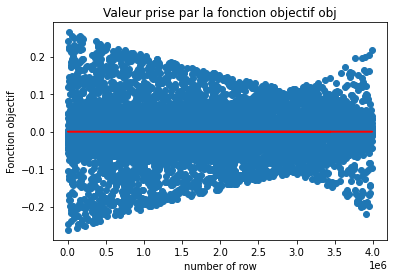

In [6]:
#Attention, on devra faire varier dt et dx (=dy)
dx=1/1001 #?
dy=1/1001 #?
dt=0.01 #?

#Calcul fonction objectif
w = small_data['P5']
print(type(w))
obj = ((small_data['F1']-small_data['F4'])/(dx*w))+((small_data['F3']-small_data['F2'])/(dy*w))

#A retenir: j'utilise le fait que la serie 'obj' suit le meme ordre d'indentation que small_data, est-ce vrai?

absi = small_data.index
plt.scatter(absi,obj)
nul = [0 for i in range((small_data.shape)[0])]
plt.plot(absi,nul,'r')
plt.title('Valeur prise par la fonction objectif obj')
plt.xlabel('number of row')
plt.ylabel('Fonction objectif')

# Scaler les données

but : moyenne = 0 et Ecart type = 1 >> recours a la fonction : preprocessing.StandardScaler()



In [7]:
#On normalise avec scaler classique sur tout
x=small_data.values
scaler = preprocessing.StandardScaler()
x_scaled = scaler.fit_transform(x)
data_scaled = pd.DataFrame(x_scaled)
col = ['P1','P2','P3','P4','P5','P6','P7','P8','P9','F1','F2','F3','F4','A1','B1','A2','B2','A3','B3','A4','B4']
data_scaled.columns = ['P1','P2','P3','P4','P5','P6','P7','P8','P9','F1','F2','F3','F4','A1','B1','A2','B2','A3','B3','A4','B4']

print('moyenne:',scaler.mean_)
print('std',scaler.var_)


###Introduction inverse transform pour les flux
output_unscaled = small_data[['F1','F2','F3','F4']]
output_unscaled_values = output_unscaled.values
output_scaler = preprocessing.StandardScaler()
output_scaled_values = output_scaler.fit_transform(output_unscaled_values)

###Introduction inverse transform pour les valeurs d'entree du réseau
input_unscaled = small_data[['P1','P2','P3','P4','P5','P6','P7','P8','P9','A1','B1','A2','B2','A3','B3','A4','B4']]
input_unscaled_values = input_unscaled.values
input_scaler = preprocessing.StandardScaler()
input_scaler.fit(input_unscaled_values)

moyenne: [ 1.60396547e-01  1.60416232e-01  1.60436281e-01  1.60406544e-01
  1.60371121e-01  1.60297751e-01  1.60306837e-01  1.60285684e-01
  1.60345583e-01  7.72808417e-05  7.80860777e-05  7.81018498e-05
  7.72662893e-05 -5.67106104e-03  6.29223618e-03 -7.46448427e-03
  8.91523874e-03 -7.27952707e-03  8.26281048e-03 -6.31795292e-03
  6.09525853e-03]
std [8.68567895e-02 8.68693803e-02 8.68823698e-02 8.68393253e-02
 8.68225164e-02 8.67801806e-02 8.67638511e-02 8.67600126e-02
 8.67886545e-02 2.71774223e-08 2.74562837e-08 2.74683068e-08
 2.71699468e-08 5.02437863e-01 4.97490384e-01 5.02311599e-01
 4.97553201e-01 5.02325330e-01 4.97553405e-01 5.02432055e-01
 4.97490876e-01]


StandardScaler()

# Extraire une 'petite' base de donnée de table.db, taille de l'ordre de 10 000

In [8]:
#data_scaled_extraite=data_scaled.sample(frac=0.0025,random_state=0) #extraire 
#data_scaled_extraite=shuffle(data_scaled_extraite) #shuffle

data_scaled_extraite=data_scaled
Data_copy=data_scaled_extraite.copy()

## Diviser la base de donnée 0.7 > entrainement ET 0.3 > test

In [9]:
print('The shape of the initial data before spliting it'+str(data_scaled_extraite.shape))


data_training=data_scaled_extraite.sample(frac=0.7,random_state=0) 
data_test=data_scaled_extraite.drop(data_training.index)

print('The shape of the initial data for training'+str(data_training.shape))
print('The shape of the initial data for testing'+str(data_test.shape))


data_training_labels = pd.DataFrame(columns =['F1','F2','F3','F4'])
data_test_labels = pd.DataFrame(columns =['F1','F2','F3','F4'])

data_training_labels['F1']=data_training['F1']
data_training_labels['F2']=data_training['F2']
data_training_labels['F3']=data_training['F3']
data_training_labels['F4']=data_training['F4']


data_test_labels['F1']=data_test['F1']
data_test_labels['F2']=data_test['F2']
data_test_labels['F3']=data_test['F3']
data_test_labels['F4']=data_test['F4']


data_training.pop('F1')
data_training.pop('F2')
data_training.pop('F3')
data_training.pop('F4')

data_test.pop('F1')
data_test.pop('F2')
data_test.pop('F3')
data_test.pop('F4')

data_training_features=data_training
data_test_features=data_test

print('The shape of the features dataframe for training'+str(data_training_features.shape))
print('The shape of the features dataframe for testing'+str(data_test_features.shape))
print('The shape of the labels dataframe for training'+str(data_training_labels.shape))
print('The shape of the labels dataframe for testing'+str(data_test_labels.shape))


The shape of the initial data before spliting it(9980, 21)
The shape of the initial data for training(6986, 21)
The shape of the initial data for testing(2994, 21)
The shape of the features dataframe for training(6986, 17)
The shape of the features dataframe for testing(2994, 17)
The shape of the labels dataframe for training(6986, 4)
The shape of the labels dataframe for testing(2994, 4)


## Créer le modèle de réseau de neurones ( fonction d'activation = LeakyRelu ) 

Définir shape = nombre de 'features' d'entrée

In [10]:
shape = len(data.columns)-4

On crée le réseau de neuronnes avec une implémentation du Dropout, BUT : Regularisation et diminuer l'effet du overfitting (Dropout > randomly reducing the number of interconnecting neurons within a neural network), on choisit le dropout_rate=0.2, et on l'applique sur toute les Hidden layers.




Define Loss functionaa

function(y_true (type:tensor), y_pred (type:tensor))
returns: loss (type: scaler)


In [60]:
def f_loss(y_true, y_pred):
    
    dx_tensor=tf.constant(1/1001)
    dy_tensor=tf.constant(1/1001)
    e = 0.000001
    n = 2
    
    wobj_list = tf.TensorArray(tf.float32, size=0, dynamic_size=True)
    for i in range(0,tf.shape(y_pred)[0]):        
        wobj_list = wobj_list.write(i,tf.add(tf.divide(tf.subtract(y_pred[i][0],y_pred[i][3]),dx_tensor),tf.divide(tf.subtract(y_pred[i][2],y_pred[i][1]),dy_tensor)))
        
    wobj = wobj_list.stack()
        
    mse = tf.reduce_mean(tf.square(tf.subtract(y_true,y_pred)))
    rest = e*pow(tf.maximum(0.0,-wobj),n)
    
    loss = mse + tf.reduce_mean(rest)
    
    return loss    

Nombre de degré de liberté du réseau : 6 051 , du meme ordre de la taille de la base de données => Overfitting/Underfitting évité

Optimiser le réseau, on choisit l'algorithm Adam et 20 000 epoches ( on peut changer d'algorithm d'optimisation apres ( gradient descent par exemple ), ca dependra de la performance ) 
On a pas encore Etudié le batch_size, on met une valeur arbitraire de 128

In [61]:
def build_model():
    model = keras.Sequential()
    model.add(layers.Dense(17,use_bias=True,input_shape=[shape],activation='elu'))
    model.add(keras.layers.Dropout(rate=0.2))
    
    model.add(layers.Dense(70,use_bias=True,input_shape=[shape],activation='elu'))
    model.add(keras.layers.Dropout(rate=0.2))
    
    model.add(layers.Dense(30,use_bias=True,input_shape=[shape],activation='elu'))
    model.add(keras.layers.Dropout(rate=0.2))
    
    model.add(layers.Dense(70,use_bias=True,input_shape=[shape],activation='elu'))
    model.add(keras.layers.Dropout(rate=0.2))
    
    model.add(layers.Dense(4,use_bias=True,activation='elu'))

    return model

model = build_model()
model.summary()

def train_model():
  
    
  optimizer = tf.optimizers.Adam() #Algorithm d'optimisation

  model.compile(loss=f_loss,
                optimizer='adam',
                metrics=['mse'])

  early_stop = keras.callbacks.EarlyStopping(monitor='val_mse',min_delta=1e-17, patience=10)
  logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1,profile_batch=0)


  model.fit(data_training_features, 
            data_training_labels, 
            epochs=2000,
            batch_size=120,
            validation_split = 0.5, 
            verbose=0, 
            callbacks=[early_stop,tensorboard_callback])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 17)                306       
_________________________________________________________________
dropout_16 (Dropout)         (None, 17)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 70)                1260      
_________________________________________________________________
dropout_17 (Dropout)         (None, 70)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 30)                2130      
_________________________________________________________________
dropout_18 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 70)               

La méthode callbacks.TensorBoard() a été ajouté pour conserver la performence du Réseau de neurones a chaque itération (epochs) et visualiser les courbes a la fin

# Save the model in .h5 format 

In [62]:
train_model()
model.save("Advection2D_contrainteLoss.h5")

# Résultats

In [63]:
Y_pred_scaled=model.predict(data_test_features) #output du réseau, qu'on veut comparer a Y_test
Y_test_scaled=data_test_labels

Y_pred_df=pd.DataFrame(Y_pred_scaled,columns=['F1','F2','F3','F4'])


In [64]:
Y_pred_unscaled = output_scaler.inverse_transform(Y_pred_scaled)
Y_test_unscaled = output_scaler.inverse_transform(Y_test_scaled)

Y_pred_unscaled_df = pd.DataFrame(Y_pred_unscaled,columns=['F1','F2','F3','F4'])
Y_test_unscaled_df = pd.DataFrame(Y_test_unscaled,columns=['F1','F2','F3','F4'])


Affichage de la fontion wobj dénormalisés

moyenne: 0.003963083028793335
ecart-type: 0.0015777554363012314
moyenne du scaler[7.72808417e-05 7.80860777e-05 7.81018498e-05 7.72662893e-05]
variance du scaler[2.71774223e-08 2.74562837e-08 2.74683068e-08 2.71699468e-08]
nb de wobj_unscaled effectué positif: 2994
nb de wobj_unscaled effectué négatif: 0


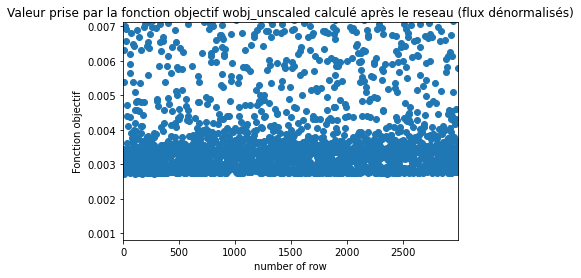

In [65]:
#On va étudier avec wobj en dénormalisé
dx=1/1001 #? Attention; ils ne sont pas normalisés ceux-là!
dy=1/1001 #?
dt=0.01 #?
wobj_unscaled = ((Y_pred_unscaled_df['F1']-Y_pred_unscaled_df['F4'])/(dx))+((Y_pred_unscaled_df['F3']-Y_pred_unscaled_df['F2'])/(dy))

absi = wobj_unscaled.index
plt.scatter(absi,wobj_unscaled)
print('moyenne:',wobj_unscaled.mean())
print('ecart-type:',wobj_unscaled.std())
nul = [0 for i in range((wobj_unscaled.shape)[0])]
plt.plot(absi,nul,'r')


x_min = absi[0]
x_max = absi.shape[0]
y_max = wobj_unscaled.mean() + 2*wobj_unscaled.std()
y_min = wobj_unscaled.mean() - 2*wobj_unscaled.std()
print('moyenne du scaler'+str(output_scaler.mean_))
print('variance du scaler'+str(output_scaler.var_))

plt.title('Valeur prise par la fonction objectif wobj_unscaled calculé après le reseau (flux dénormalisés)')
plt.xlabel('number of row')
plt.ylabel('Fonction objectif')
plt.axis([x_min, x_max, y_min, y_max])


### Ici tout est dénormalisé
wobj_unscaled = wobj_unscaled.to_frame()
wobj_unscaled.columns = ['wobj_unscaled']

au_dessus_realise = wobj_unscaled.loc[wobj_unscaled['wobj_unscaled']>=0]
nb_au_dessus_realise = au_dessus_realise.shape[0]
print('nb de wobj_unscaled effectué positif: '+str(nb_au_dessus_realise))
en_dessous_realise = wobj_unscaled.loc[wobj_unscaled['wobj_unscaled']<0]
nb_en_dessous_realise = en_dessous_realise.shape[0]
print('nb de wobj_unscaled effectué négatif: '+str(nb_en_dessous_realise))


In [66]:
def visualize1(): #we feed it the test data
    plt.scatter(data_test_labels['F1'],Y_pred_df['F1'], color = 'red',marker=".")
    plt.scatter(data_test_labels['F1'],data_test_labels['F1'], color = 'black',marker=".") #just for the y=x black line, the result (red points) should be close to the line
    
    plt.title('Neural Network prediction de F1')
    plt.xlabel('exact')
    plt.ylabel('prediction')
    
    R2=metrics.r2_score(data_test_labels, Y_pred_df)
    
    Correl=np.corrcoef(data_test_labels, Y_pred_df)[0, 1]
    
    print('Model Performance')
    print('Correlation: {:0.4f}.'.format(Correl))
    print('R2: {:0.4f}.'.format(R2))
    
    plt.show()   


In [67]:
def visualize2(): #we feed it the test data
    plt.scatter(data_test_labels['F2'],Y_pred_df['F2'], color = 'red',marker=".")
    plt.scatter(data_test_labels['F2'],data_test_labels['F2'], color = 'black',marker=".") #just for the y=x black line, the result (red points) should be close to the line
    
    
    plt.title('Neural Network prediction de F2')
    plt.xlabel('exact')
    plt.ylabel('prediction')
    
    R2=metrics.r2_score(data_test_labels, Y_pred_df)
    
    Correl=np.corrcoef(data_test_labels, Y_pred_df)[0, 1]
    
    print('Model Performance')
    print('Correlation: {:0.4f}.'.format(Correl))
    print('R2: {:0.4f}.'.format(R2))
    
    plt.show()

In [68]:
def visualize3(): #we feed it the test data
    plt.scatter(data_test_labels['F3'],Y_pred_df['F3'], color = 'red',marker=".")
    plt.scatter(data_test_labels['F3'],data_test_labels['F3'], color = 'black',marker=".") #just for the y=x black line, the result (red points) should be close to the line
    
    
    plt.title('Neural Network prediction de F3')
    plt.xlabel('exact')
    plt.ylabel('prediction')
    
    R2=metrics.r2_score(data_test_labels, Y_pred_df)
    
    Correl=np.corrcoef(data_test_labels, Y_pred_df)[0, 1]
    
    print('Model Performance')
    print('Correlation: {:0.4f}.'.format(Correl))
    print('R2: {:0.4f}.'.format(R2))
    
    plt.show()

In [69]:
def visualize4(): #we feed it the test data
    plt.scatter(data_test_labels['F4'],Y_pred_df['F4'], color = 'red',marker=".")
    plt.scatter(data_test_labels['F4'],data_test_labels['F4'], color = 'black',marker=".") #just for the y=x black line, the result (red points) should be close to the line
    
    
    plt.title('Neural Network prediction de F4')
    plt.xlabel('exact')
    plt.ylabel('prediction')
    
    R2=metrics.r2_score(data_test_labels, Y_pred_df)
    
    Correl=np.corrcoef(data_test_labels, Y_pred_df)[0, 1]
    
    print('Model Performance')
    print('Correlation: {:0.4f}.'.format(Correl))
    print('R2: {:0.4f}.'.format(R2))
    
    plt.show()

Model Performance
Correlation: 1.0000.
R2: 0.9537.


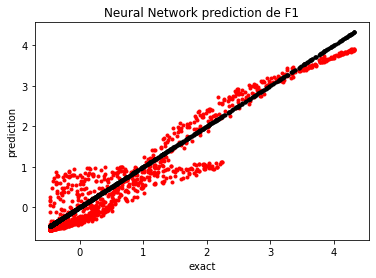

In [70]:
visualize1()

Model Performance
Correlation: 1.0000.
R2: 0.9537.


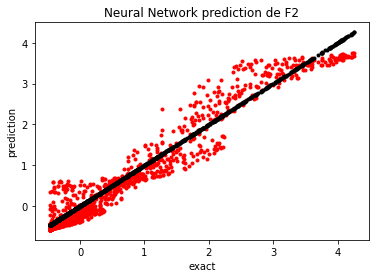

In [71]:
visualize2()

Model Performance
Correlation: 1.0000.
R2: 0.9537.


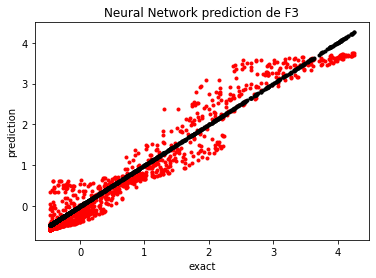

In [72]:
visualize3()

Model Performance
Correlation: 1.0000.
R2: 0.9537.


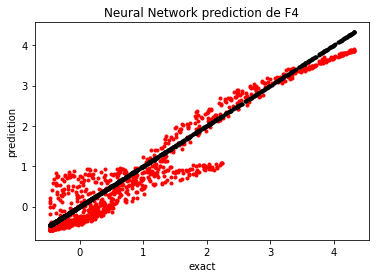

In [73]:
visualize4()

# Visualisation de la Loss-fonction

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs/fit